# **Progetto Intelligenza Artificiale 2023/2024**



# **Obiettivo analisi**
Analisi dataset Breast Cancer Wisconsin con particolare riferimento alla possibilità di prevedere la diagnosi (tumore maligno/benigno).







installazione modulo per importazione dataset

In [4]:
pip install ucimlrepo

# Import librerie e dataset


In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score as AS, confusion_matrix as CM, recall_score as RS, ConfusionMatrixDisplay, precision_score as PS, make_scorer, recall_score, f1_score, make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

import numpy as np
import pandas as pd

from ucimlrepo import fetch_ucirepo

#database: https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic
breast_cancer = fetch_ucirepo(id=17)

#lista di nomi delle variabili
names = breast_cancer.variables.name.iloc[2:].tolist()

#inizializzo il dizionario delle metriche dei modelli
statistiche_confusione = {}

#definisco il seed
rand = 1

# Funzioni di Allenamento e Valutazione


In [24]:
# visualizza la matrice di confusione e aggiunge le metriche del modello al dizionario delle metriche

def metrics_calculation(key_dizionario, preds, use_all_y = False):
  if use_all_y:
    test = y
  else:
    test = y_test
  conf_matrix = CM(test, preds)
  #Visualizziamo la matrice di confusione
  disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels= ['B', 'M'])
  disp.plot()
  plt.show()

  #Ci interessa che la quantità di M riconosciuta sia il più alta possibile
  labelRecall = 'M'
  #Ci interessa che le diagnosi di B siano il più vere possibili
  labelPrecision = 'B'

  #Calcoliamo le metriche
  accuracy = round(AS(test, preds), 3)
  recall = round(RS(test, preds, pos_label=labelRecall), 3)
  precision = round(PS(test, preds, pos_label=labelPrecision), 3)

  print("\naccuracy: " + str(accuracy))
  print("recall di "+ labelRecall + ": " + str(recall))
  print("precision di "+ labelPrecision + ": " + str(precision))

  #Teniamo un dizionario contenente le metriche d'interesse per ogni modello allenato
  statistiche_confusione[key_dizionario] = [accuracy, recall, precision]

#esegue la ricerca degli iperparametri di uno stimatore con GridsearchCV e richiama metrics_calculation

def fit_valutation_Grid(estimator, parameters, key_dizionario):

  clfSearchCV = GridSearchCV(estimator, parameters, n_jobs = -1, cv = 2, scoring = make_scorer(custom_f1_scorer))

  clfSearchCV.fit(x_train, np.ravel(y_train))

  print(clfSearchCV.best_params_)

  predictions = clfSearchCV.predict(x_test)

  metrics_calculation(key_dizionario, predictions)


#esegue la ricerca degli iperparametri di uno stimatore con RandomizedCV e richiama metrics_calculation


def fit_valutation_Randomized(estimator, parameters, key_dizionario):

  clfSearchCV = RandomizedSearchCV(estimator, parameters, cv = 2, random_state= rand, n_iter= 100, scoring = make_scorer(custom_f1_scorer))

  clfSearchCV.fit(x_train, np.ravel(y_train))

  print(clfSearchCV.best_params_)

  predictions = clfSearchCV.predict(x_test)

  metrics_calculation(key_dizionario, predictions)

  return clfSearchCV.best_estimator_

# funzione di score modificata

def custom_f1_scorer(y_true, y_pred):
  Rs = RS(y_true, y_pred, pos_label = 'M')
  Ps = PS(y_true, y_pred, pos_label = 'B')
  As = AS(y_true, y_pred)

  return  2 * Rs * Ps/(Rs + Ps)

#ritorna la fature più incidente nella classificazione, utilizzabile in modelli che usano alberi

def valutazione_features(estimator):
  fi = estimator.feature_importances_
  iMax = 0
  max = 0
  for i in range(len(fi)):
    print("Feature: " + names[i] + ", importanza feature: " + str(fi[i]))
    if fi[i]>max:
      max = fi[i]
      iMax = i

  print("feature di maggiore importanza: " + names[iMax] + ", valore: " +str(max))

#crea aggiunge l'elemento None ad una lista data dagli elementi interni a Range

def NoneRange(start = 0, end = 1, step = 1):
  var = [None,]
  for i in range(start, end, step):
    var.append(i)
  return var

#NoneRange frazionario, divide per "ordineGrandezza"

def frac_range( startNum = 0, endNum = 1, step = 1, ordineGrandezza = 1):
  ra = []
  for i in range(startNum, endNum, step):
    ra.append(i/ordineGrandezza)
  return ra

# Analisi qualitativa del dataset
Per prima cosa facciamo delle prime stime sul dataset

1.   dimensione dataset
2. numero di features
3. tipo di classificazione




In [7]:
print("numero di features: " + str(breast_cancer.metadata.num_features))
print("numero di instanze: " + str(breast_cancer.metadata.num_instances))
print(breast_cancer.data.original["Diagnosis"].value_counts())


numero di features: 30
numero di instanze: 569
B    357
M    212
Name: Diagnosis, dtype: int64


Dai metadati forniti con il dataset si scopre che il dataset è composto da  569 campioni ognuno da 30 features senza valori mancanti.\
Sul dataset verrà effettuata una classificazione dicotomica su casi maligni e benigni.


# Split dati - holdout
Per la suddivisione dei dati abbiamo deciso di utilizzare una suddivisione holdout:
- 80% dei dati per la fase di training
- 20% per la fase di test

In [8]:
# data
x = breast_cancer.data.features
y = breast_cancer.data.targets


# normalizzo i dati
scaler = StandardScaler()
x = scaler.fit_transform(x)

#partiziono i dati
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=rand, stratify = y)

print("Dimensioni del set di addestramento:")
print("x_train:", x_train.shape)
print("y_train:", y_train.shape)
print("\nDimensioni del set di test:")
print("x_test:", x_test.shape)
print("y_test:", y_test.shape)

Dimensioni del set di addestramento:
x_train: (455, 30)
y_train: (455, 1)

Dimensioni del set di test:
x_test: (114, 30)
y_test: (114, 1)


# Classificazione


## Albero decisionale



{'splitter': 'best', 'min_samples_split': 2, 'min_samples_leaf': 8, 'max_leaf_nodes': 16, 'max_features': None, 'max_depth': 10, 'criterion': 'log_loss'}


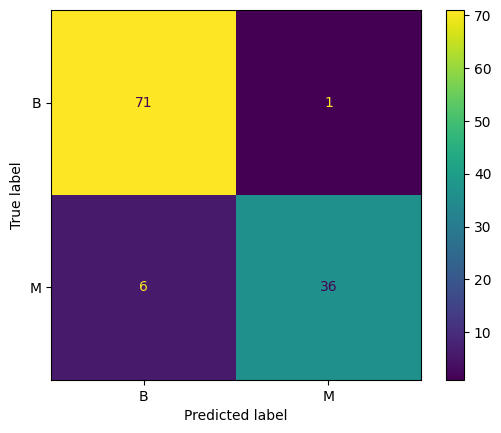


accuracy: 0.939
recall di M: 0.857
precision di B: 0.922


DecisionTreeClassifier(criterion='log_loss', max_depth=10, max_leaf_nodes=16,
                       min_samples_leaf=8, random_state=1)

In [9]:
clf = DecisionTreeClassifier(random_state = rand)
parameters = {'criterion': ['gini', 'entropy', 'log_loss'],
              'splitter': ['best', 'random'],
              'max_depth' : NoneRange(1, 12),
              'min_samples_split': range(2, 10),
              'min_samples_leaf': range(1, 10),
              'max_leaf_nodes': range(2, 20),
              'max_features' : ['sqrt', 'log2', None]}

fit_valutation_Randomized(clf, parameters, 'tree')

## K nearest neighbor

{'weights': 'distance', 'n_neighbors': 4, 'leaf_size': 38, 'algorithm': 'kd_tree'}


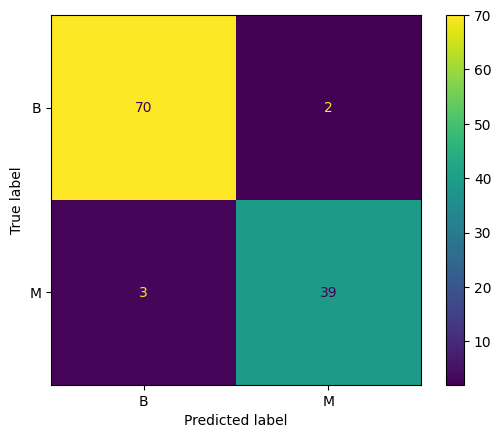


accuracy: 0.956
recall di M: 0.929
precision di B: 0.959


KNeighborsClassifier(algorithm='kd_tree', leaf_size=38, n_neighbors=4,
                     weights='distance')

In [10]:
knn = KNeighborsClassifier(n_neighbors=6)
parameters = {'n_neighbors': range(3, 10),
              'weights' : ['uniform', 'distance'],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'leaf_size': range(20, 40)}

fit_valutation_Randomized(knn, parameters, 'knn')


# Random Forest

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 36 is smaller than n_iter=100. Running 36 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


{'n_estimators': 1400, 'min_samples_split': 2, 'min_samples_leaf': 1}


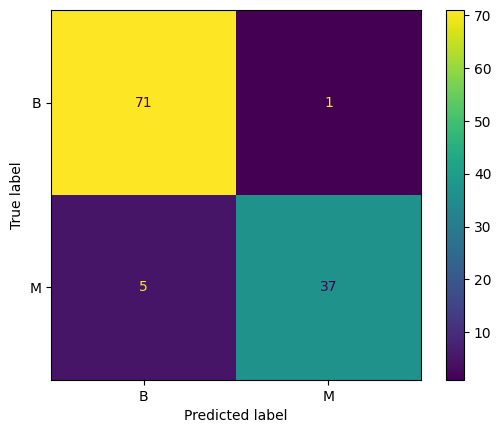


accuracy: 0.947
recall di M: 0.881
precision di B: 0.934


RandomForestClassifier(max_depth=10, n_estimators=1400, random_state=1)

In [11]:
rforest = RandomForestClassifier(random_state= rand, bootstrap=True, max_depth = 10, max_features = "sqrt")

parameters = {
              'n_estimators': range(1200, 2000,  200),
               'min_samples_split':[2, 5, 10],
               'min_samples_leaf': [1, 2, 4],
             }


fit_valutation_Randomized(rforest, parameters, 'rforest')

# AdaBoost

{'n_estimators': 60, 'learning_rate': 0.5}


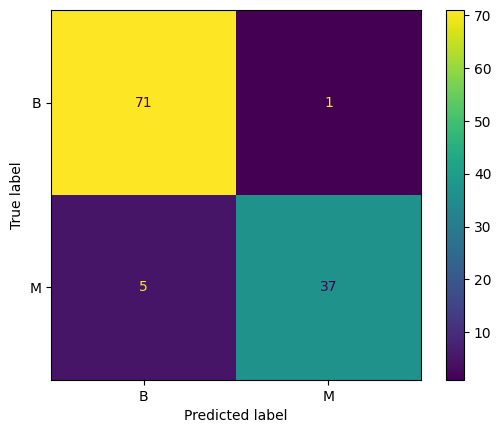


accuracy: 0.947
recall di M: 0.881
precision di B: 0.934


AdaBoostClassifier(algorithm='SAMME', learning_rate=0.5, n_estimators=60,
                   random_state=1)

In [12]:
ada = AdaBoostClassifier(random_state = rand, algorithm = 'SAMME')

parameters = {'n_estimators' : range(10, 200, 10),
              'learning_rate' : frac_range(1, 20, 1, 10)}

fit_valutation_Randomized(ada, parameters, 'Ada')

# Gradient Boosting

{'n_estimators': 30, 'min_weight_fraction_leaf': 0.0, 'min_samples_split': 11, 'max_features': 'log2', 'loss': 'log_loss', 'learning_rate': 0.4, 'criterion': 'squared_error'}


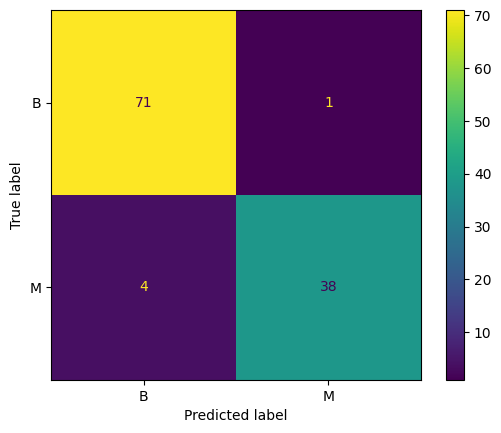


accuracy: 0.956
recall di M: 0.905
precision di B: 0.947


GradientBoostingClassifier(criterion='squared_error', learning_rate=0.4,
                           max_features='log2', min_samples_split=11,
                           n_estimators=30, random_state=1)

In [13]:
xgb = GradientBoostingClassifier(random_state = rand,
                                 criterion = 'friedman_mse',
                                 max_features = 'log2')

parameters = {'loss': ['log_loss', 'exponential'],
              'n_estimators': range(10, 310, 10),
              'learning_rate' : frac_range(5, 55, 5, 100),
              'criterion': ['friedman_mse', 'squared_error'],
              'max_features': ['sqrt', 'log2'],
              'min_samples_split' : range(2, 20),
              'min_weight_fraction_leaf' : frac_range(0, 5, 5, 10)
              }


fit_valutation_Randomized(xgb, parameters, 'xgb')

# Regressione logistica

{'penalty': 'l2', 'dual': False}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 8 is smaller than n_iter=100. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
12 fits failed out of a total of 16.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py"

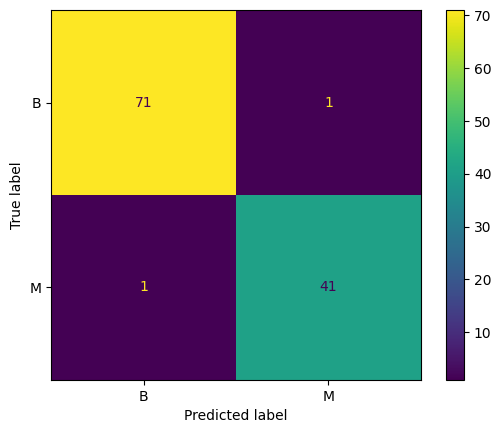


accuracy: 0.982
recall di M: 0.976
precision di B: 0.986


LogisticRegression(random_state=0)

In [14]:
parameters = {'penalty' : ['l1', 'l2', 'elasticnet', None],
              'dual': [True, False]}

clf = LogisticRegression(random_state=0)

fit_valutation_Randomized(clf, parameters, 'lregression')


# Neural network

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptro

{'solver': 'adam', 'max_iter': 300, 'hidden_layer_sizes': (20, 20), 'early_stopping': True, 'alpha': 1e-08, 'activation': 'identity'}


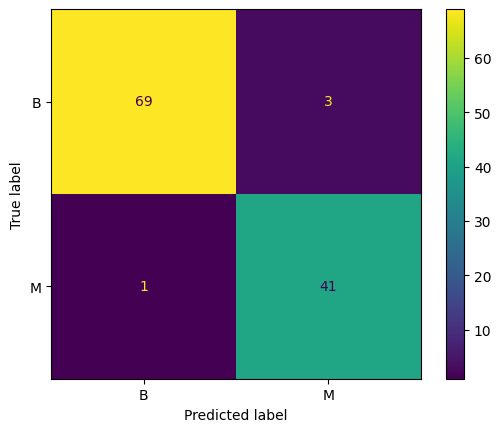


accuracy: 0.965
recall di M: 0.976
precision di B: 0.986


MLPClassifier(activation='identity', alpha=1e-08, early_stopping=True,
              hidden_layer_sizes=(20, 20), max_iter=300, random_state=1)

In [15]:
clf = MLPClassifier(random_state= rand)

parameters = {
    'hidden_layer_sizes': [(20, 20), (30, 30), (20, 15, 10)],
    'activation': ['identity', 'logistic', 'tanh', 'relu'],
    'solver': ["adam","lbfgs"],
    'early_stopping' : [True, False],
    'alpha': [10**(-8), 10**(-7), 10**(-6), 10**(-5)],
    'max_iter': [300, 400, 500]
}

fit_valutation_Randomized(clf, parameters, "nn")

# SVC


In [16]:
from sklearn.svm import SVC

{'shrinking': True, 'kernel': 'rbf', 'gamma': 'scale', 'degree': 2, 'decision_function_shape': 'ovo', 'C': 10}


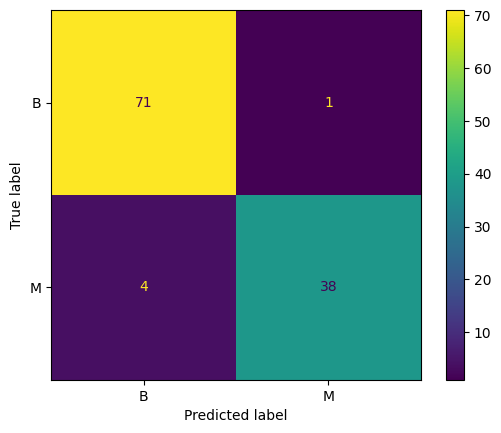


accuracy: 0.956
recall di M: 0.905
precision di B: 0.947


SVC(C=10, decision_function_shape='ovo', degree=2)

In [17]:
clf = SVC()
parameters = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto'],
    'degree': [2, 3, 4, 5],
    'shrinking': [True, False],
    'decision_function_shape': ['ovo', 'ovr']
}
fit_valutation_Randomized(clf, parameters, 'SVC')

# Confronto

In [18]:
print("statistiche della matrice di confusione per ogni modello:\n")

for key in statistiche_confusione.keys():
  print("modello: " + str(key) +
        ", accuracy: " + str(statistiche_confusione[key][0]) +
        ", recall di M: "+ str(statistiche_confusione[key][1]) +
        ", precision di B: " + str(statistiche_confusione[key][2])+
        ", media armonica: " + str(2 * statistiche_confusione[key][1] * statistiche_confusione[key][2] /  (statistiche_confusione[key][1] + statistiche_confusione[key][2])))


print("\nOVERALL:-------------------------------------\n")

indexMaxOverall = 'tree'
valMaxOverall = 0
indexMaxPrec = 'tree'
valMaxPrec = 0

for key in statistiche_confusione.keys():

  overall = statistiche_confusione[key][0]+statistiche_confusione[key][1]+statistiche_confusione[key][2]

  if overall > valMaxOverall:
    indexMaxOverall = key
    valMaxOverall = overall

  if statistiche_confusione[key][1] > valMaxPrec:
    indexMaxPrec = key
    valMaxPrec = statistiche_confusione[key][1]

  print("modello: " + str(key) + ", overall: " + str(overall))


print("\nOVERALL PESATO:-------------------------------------\n")
#Vogliamo considerare "migliore" il modello che ha buone metriche in generale, ma con una spiccata recall su M
indexMaxOverallPesato = 'tree'
valMaxOverallPesato = 0

for key in statistiche_confusione.keys():
  overallPesato = statistiche_confusione[key][0]+2 * statistiche_confusione[key][1]+statistiche_confusione[key][2]

  if overallPesato > valMaxOverallPesato:
    indexMaxOverallPesato = key
    valMaxOverallPesato = overallPesato

  print("modello: " + str(key) + ", overall pesato: " + str(overallPesato))

print("\nMASSIMI:--------------------------------\n")

print("max precision: "+ str(indexMaxPrec) + ", valore = " + str(valMaxPrec))
print("max overall: " + str(indexMaxOverall) + ", valore = " + str(valMaxOverall) + ", precision = " + str(statistiche_confusione[indexMaxOverall][1]))
print("max overall pesato: " + str(indexMaxOverallPesato)+ ", valore = " + str(valMaxOverallPesato) + ", precision = " + str(statistiche_confusione[indexMaxOverallPesato][1]))



statistiche della matrice di confusione per ogni modello:

modello: tree, accuracy: 0.939, recall di M: 0.857, precision di B: 0.922, media armonica: 0.8883125351320967
modello: knn, accuracy: 0.956, recall di M: 0.929, precision di B: 0.959, media armonica: 0.943761652542373
modello: rforest, accuracy: 0.947, recall di M: 0.881, precision di B: 0.934, media armonica: 0.9067261707988982
modello: Ada, accuracy: 0.947, recall di M: 0.881, precision di B: 0.934, media armonica: 0.9067261707988982
modello: xgb, accuracy: 0.956, recall di M: 0.905, precision di B: 0.947, media armonica: 0.9255237580993521
modello: lregression, accuracy: 0.982, recall di M: 0.976, precision di B: 0.986, media armonica: 0.9809745158002039
modello: nn, accuracy: 0.965, recall di M: 0.976, precision di B: 0.986, media armonica: 0.9809745158002039
modello: SVC, accuracy: 0.956, recall di M: 0.905, precision di B: 0.947, media armonica: 0.9255237580993521

OVERALL:-------------------------------------

modello: t

# Visualizzazione

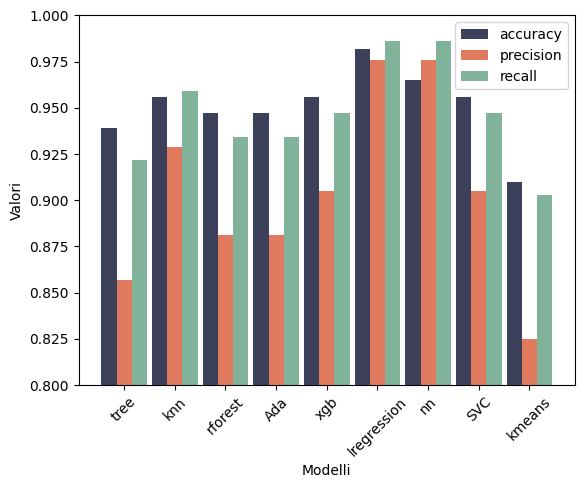

In [46]:
# Dati di esempio
modelli = statistiche_confusione.keys()
accuracy = []
precision = []
recall = []

for key in statistiche_confusione:
  accuracy.append(statistiche_confusione[key][0])
  recall.append(statistiche_confusione[key][1])
  precision.append(statistiche_confusione[key][2])
barW = 0.30

r1 = np.arange(len(modelli))
r2 = [x + barW for x in r1]
r3 = [x + barW for x in r2]

# Plot dell'istogramma con tre serie di dati
plt.bar(r1, accuracy, color='#3D405B', width = barW, label='accuracy')
plt.bar(r2, recall, color='#E07A5F',width = barW, label='precision')
plt.bar(r3, precision, color='#81B29A',width = barW, label='recall')

# Aggiungi etichette agli assi e un titolo
plt.xlabel('Modelli')
plt.xticks([r + barW for r in range(len(modelli))], modelli, rotation = 45)

plt.ylabel('Valori')
plt.ylim(0.8, 1)
# Aggiungi una legenda
plt.legend()

# Mostra il grafico
plt.show()



# Valutazione con F1

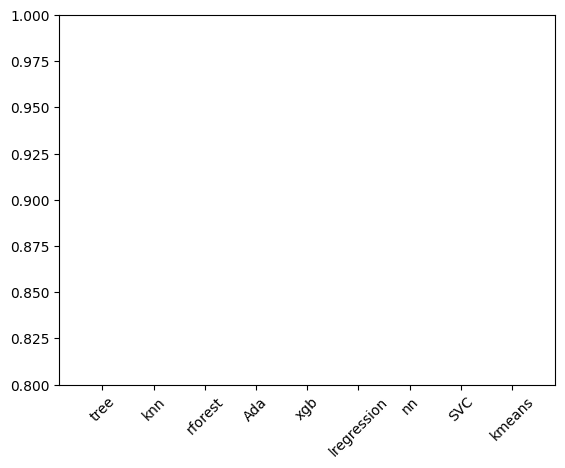

In [51]:
F1 = []
for i in range(len(statistiche_confusione)):
  F1.append(precision[i] * recall[i] /(precision[i] + recall[i]))

plt.bar(r1, F1)
plt.xticks(r1, modelli, rotation = 45)
plt.ylim(0.8, 1)

plt.show()

# Analisi Geometrica

## K-means

In [21]:
from sklearn.cluster import KMeans

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


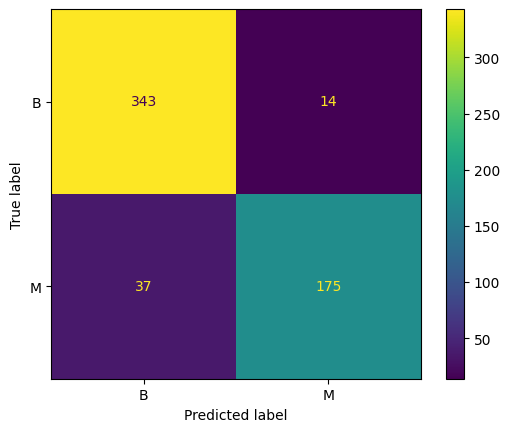


accuracy: 0.91
recall di M: 0.825
precision di B: 0.903


In [22]:
clf = KMeans(n_clusters=2, random_state=rand)
predictions_ = clf.fit_predict(x)
predictions = []
for i in range(len(predictions_)):
  if predictions_[i] == 1:
    predictions.append('M')
  else:
    predictions.append('B')

metrics_calculation('kmeans', predictions, use_all_y = True)

In [25]:
def sub(a, b):
  res = []
  for i in range(len(a)):
    res.append(a[i] - b[i])
  return res

def dist(a, b):
  return np.sqrt(np.sum(np.square(sub(a, b))))

In [26]:
centroids = clf.cluster_centers_

r_mean = [0, 0]
nElements = [0, 0]

for i in range(len(predictions_)):
  r_mean[predictions_[i]] += dist(x[i], centroids[predictions_[i]])
  nElements[predictions_[i]] += 1

r_mean[0] = r_mean[0]/nElements[0]
r_mean[1] = r_mean[1]/nElements[1]

print("distanza inter cluster: " +str(dist(centroids[0], centroids[1])))
print("raggio medio: cluster1 " + str(r_mean[0]) + ", cluster2 " + str(r_mean[1]))

distanza inter cluster: 6.58577957714617
raggio medio: cluster1 3.467836538373145, cluster2 5.174815101675073


## DBSCAN

In [27]:
from sklearn.cluster import DBSCAN

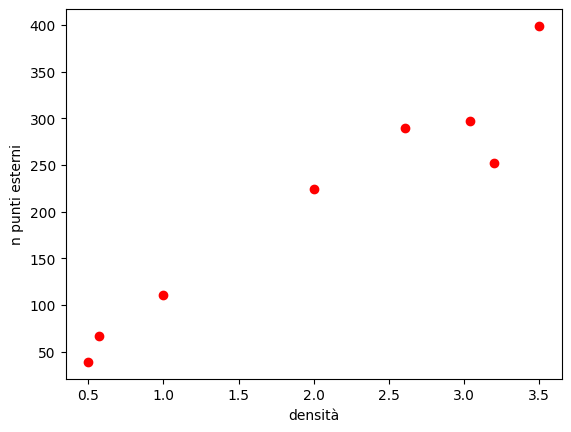

In [28]:

def boh(color, nRegioni):
  densita = []
  esterni = []
  for epsilon in [2,2.3, 2.5, 2.7, 3, 3.3, 3.5, 3.7, 4]:
    for minNeighbors in [2, 3, 4, 5, 6, 7, 8]:

      clustering = DBSCAN(eps = epsilon, min_samples = minNeighbors)
      labels = clustering.fit_predict(x)

      n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
      n_noise_ = list(labels).count(-1)
      #se il numero di cluster trovati è uguale a quello che cerchiamo allora teniamo i risultati
      if(n_clusters_ == nRegioni):
        densita.append(minNeighbors/epsilon)
        esterni.append(n_noise_)

  plt.scatter(densita, esterni, color = color)

boh('red', 2)
# boh('blue', 1)

plt.xlabel('densità')
plt.ylabel('n punti esterni')

plt.show()